## [First Place - Single Model - [LB 38.81]](https://www.kaggle.com/code/cdeotte/first-place-single-model-lb-38-81)

This notebook has 138 features. This is a simplfied version of the actual final solution which has 500 features! 
None-the-less, the notebook achieves first place accuracy!

A simple way to boost the performance of the notebook is to:
- Train 20 folds inside 20 folds instead of 7 inside 7 (or 10 in 10, or 15 in 15). 
- And we can decrease XGBoost learning rate from 0.01 to 0.005 (and change early stopping to 1000). 

This will of course increase runtime but it will also improve model accuracy too!




### Feature Engineering with Fast cuDF-Pandas!

One of the most powerful feature engineering techniques is `groupby(COL1)[COL2].agg(STAT)`. This is where we group by `COL1` column and aggregate (i.e. compute) a statistic `STAT` over another column `COL2`. This is the underlying method to compute target encoding and count encoding. By computing raw statistics and inputting them into our model, our model can do more than only receiving `TE` or `CE`. This notebook illustrates creating 50 engineered features, but we can create hundreds more and improve CV score and LB score!

**NOTE:** There are two ways to use RAPIDS cuDF. We can write cuDF code which looks just like Pandas code and starts with `import cudf`. Or we can write normal Pandas code with import pandas but before that we add the cell magic command `%load_ext cudf.pandas`. By adding this magic command all calls to Pandas afterward will use RAPIDS cuDF behind the scenes taking advantage of the massive speed boost of GPU!

In [1]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = "0"
%load_ext cudf.pandas

import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)  # or 1000

In [2]:
import os
os.chdir('./kaggle/playground/s5/e02/')
print(os.getcwd())

/mnt/d/personal/stuff/self-learn/EDA/kaggle/playground/s5/e02


In [3]:
train1, train2 = pd.read_csv("data/train.csv"), pd.read_csv('data/training_extra.csv')
train = pd.concat([train1, train2], ignore_index=True).drop(columns=['id'])

test = pd.read_csv("data/test.csv")

display(train.shape, test.shape)
train.head()

(3994318, 10)

(200000, 10)

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [4]:
train.info()  # check the data types of columns and memory usage

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 10 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Brand                 object 
 1   Material              object 
 2   Size                  object 
 3   Compartments          float64
 4   Laptop Compartment    object 
 5   Waterproof            object 
 6   Style                 object 
 7   Color                 object 
 8   Weight Capacity (kg)  float64
 9   Price                 float64
dtypes: float64(3), object(7)
memory usage: 304.7+ MB


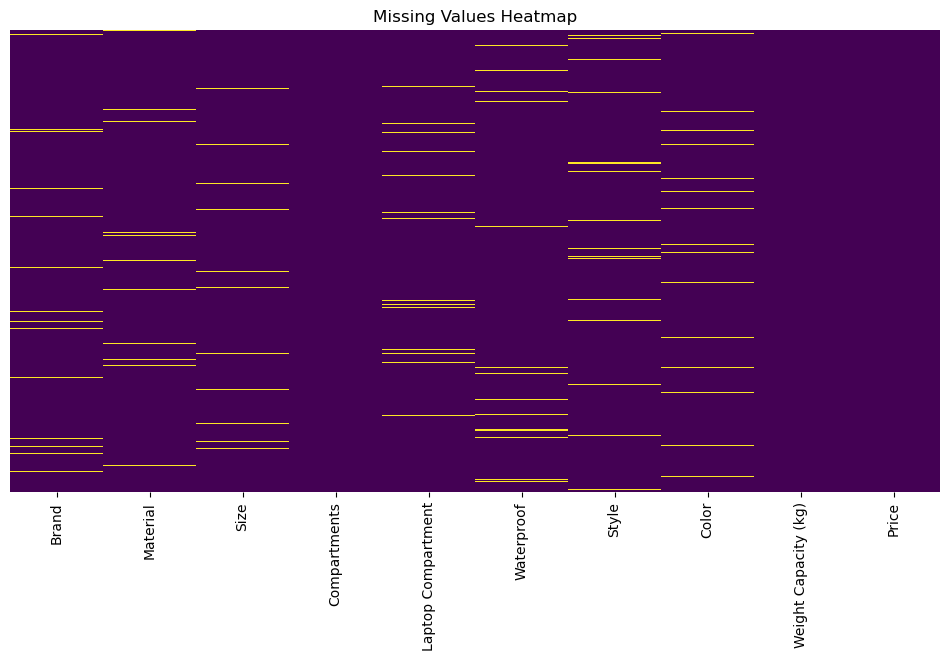

In [5]:
# Plot a heatmap to visualize missing values

import seaborn as sns
plt.figure(figsize=(12, 6))
sns.heatmap(train.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values Heatmap')
plt.show()

In [6]:
num_cols = train.select_dtypes(exclude='object').columns.tolist()
cat_cols = train.select_dtypes(include='object').columns.tolist()

# Moving Compartment into the Categorical Columns (to be binned later)
num_cols.remove('Price')
cat_cols.append(num_cols.pop(0))

print("Number of numerical columns:", len(num_cols))
print(num_cols)
print("Number of categorical columns:", len(cat_cols))
print(cat_cols)

Number of numerical columns: 1
['Weight Capacity (kg)']
Number of categorical columns: 8
['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color', 'Compartments']


,Weight Capacity (kg)
count,3992510.000
mean,18.010
std,6.974
min,5.000
25%,12.069
50%,18.054
75%,23.988
max,30.000


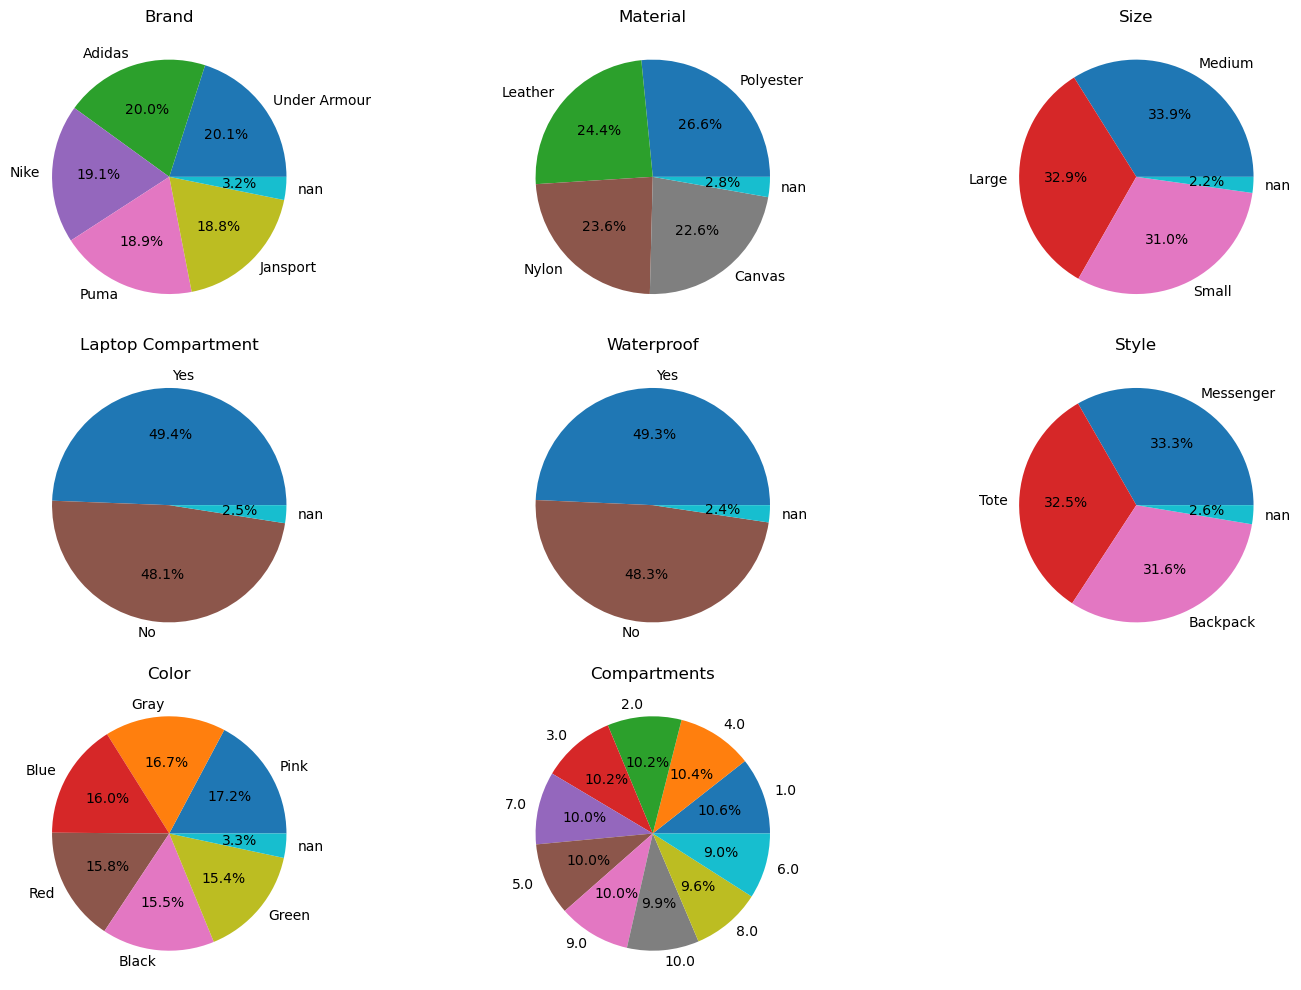

In [7]:
display(train[num_cols].describe(include='all').round(3))  # get summary statistics for numerical columns

# Visualize the distribution of categorical columns, using subplots
plt.figure(figsize=(15, 10))

for i, col in enumerate(cat_cols):
    plt.subplot(3, 3, i + 1)
    # sns.countplot(x=col, data=train, palette='viridis', legend=False)
    train[col].value_counts(dropna=False).plot(kind='pie', autopct='%1.1f%%',  colormap='tab10')
    plt.title(col)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [8]:
COMBOS = ["NaNs"]
train["NaNs"], test["NaNs"] = np.float32(0), np.float32(0)

for i, col in enumerate(cat_cols):

    """
    * New Feature: Encode all NaNs as one Base-2 feature
    Encode and accumulate all NaNs in a single feature

    ? States:
        df[col] -> Object
        df[col].isna() -> Boolean
        df["NaNs"] -> Integer (Base-2)
    """
    train["NaNs"] += train[col].isna() * 2 ** i
    test["NaNs"] += test[col].isna() * 2 ** i


    """
    * New Feature: Encode each column's NaN with weight capacity
    Encode and accumulate all NaNs in a single feature with weight capacity
    
    ? States:
        df[col] -> Object
        df[col].isna() -> Boolean
        df[new_col] -> Integer (Base-2)
    """
    new_col = f'{col}_nan_wc'
    train[new_col] = train[col].isna() * 100 + train["Weight Capacity (kg)"]
    test[new_col] = test[col].isna() * 100 + test["Weight Capacity (kg)"]
    COMBOS.append(new_col)

    """
    Convert the categorical column to numerical (similar to LabelEncode)

    ? State:
        df[col] -> Object
        pd.factorize(df[col]) -> Tuple (Encoded {Integers}, Uniques {Integers})
        df[col] -> Float32
    """
    combine = pd.concat([train[col], test[col]], axis=0)
    combine, _ = pd.factorize(combine)  # Encode the object as an enumerated type or categorical variable.
    train[col] = combine[:train.shape[0]].astype("float32")
    test[col] = combine[train.shape[0]:].astype("float32")

    """
    * New Feature: Combine the column (float32) with Weight Capacity (kg)

    State:
        df[col] -> Float32
        df[new_col] -> Float32
    """
    new_col = f'{col}_wc'
    train[new_col] = train[col] * 100 + train["Weight Capacity (kg)"]
    test[new_col] = test[col] * 100 + test["Weight Capacity (kg)"]
    COMBOS.append(new_col)

COMBOS

['NaNs',
 'Brand_nan_wc',
 'Brand_wc',
 'Material_nan_wc',
 'Material_wc',
 'Size_nan_wc',
 'Size_wc',
 'Laptop Compartment_nan_wc',
 'Laptop Compartment_wc',
 'Waterproof_nan_wc',
 'Waterproof_wc',
 'Style_nan_wc',
 'Style_wc',
 'Color_nan_wc',
 'Color_wc',
 'Compartments_nan_wc',
 'Compartments_wc']

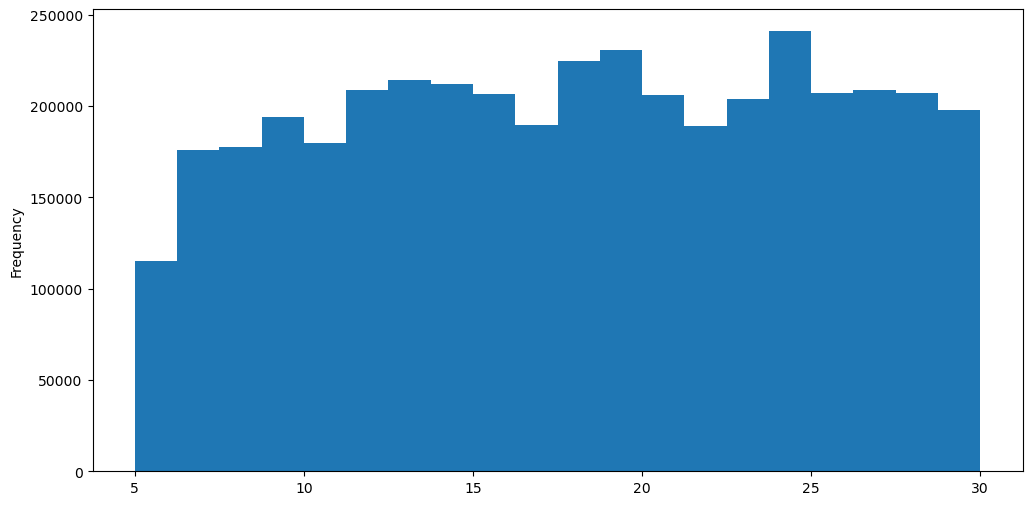

In [9]:
# train["Weight Capacity (kg)"].plot(kind="kde", figsize=(12, 6));
train["Weight Capacity (kg)"].plot(kind="hist", bins=20, figsize=(12, 6));

In [10]:

# * New Feature: Rounding off Weight Capacity (kg)

for i in range(7, 10):
    new_col = f'wc_round_{i}'
    train[new_col] = train["Weight Capacity (kg)"].round(i)
    test[new_col] = test["Weight Capacity (kg)"].round(i)
    COMBOS.append(new_col)

train[COMBOS[-3:]].head()

,wc_round_7,wc_round_8,wc_round_9
0,11.611723,11.611723,11.611723
1,27.078537,27.078537,27.078537
2,16.643760,16.643760,16.643760
3,12.937220,12.937220,12.937220
4,17.749339,17.749338,17.749338


In [11]:

# ! I DEEM THIS TO BE CHEATING (Still documenting it for reference)
# # * NEW FEATURE - ORIGINAL DATASET PRICE
# NEW_COLS = []
# orig = pd.read_csv("/kaggle/input/student-bag-price-prediction-dataset/Noisy_Student_Bag_Price_Prediction_Dataset.csv")
# tmp = orig.groupby("Weight Capacity (kg)").Price.mean()
# tmp.name = "orig_price"
# train = train.merge(tmp, on="Weight Capacity (kg)", how="left")
# test = test.merge(tmp, on="Weight Capacity (kg)", how="left")
# NEW_COLS.append("orig_price")

In [12]:
DIGITS = []

# * NEW FEATURE - Digit Extraction from Weight Capacity
for i in range(1, 10):
    new_col = f'wc_digit_{i}'
    train[new_col] = ((train['Weight Capacity (kg)'] * 10 ** i) % 10).fillna(-1).astype("int8")
    test[new_col] = ((test['Weight Capacity (kg)'] * 10 ** i) % 10).fillna(-1).astype("int8")

    DIGITS.append(new_col)
    
DIGITS

['wc_digit_1',
 'wc_digit_2',
 'wc_digit_3',
 'wc_digit_4',
 'wc_digit_5',
 'wc_digit_6',
 'wc_digit_7',
 'wc_digit_8',
 'wc_digit_9']

In [13]:

# * NEW FEATURE - Combination of Digits
# NOTE: Multiplying by 11 ensures a one-to-one mapping between the pair of digits and the created feature, 
# which is useful in feature engineering to capture unique combinations without ambiguity.

for i in range(4):
    for j in range(i + 1, 5):
        new_col = f'wc_digits_{i + 1}_{j + 1}'
        train[new_col] = ((train[f'wc_digit_{i + 1}'] + 1) * 11 + train[f'wc_digit_{j + 1}']).astype("int8")
        test[new_col] = ((test[f'wc_digit_{i + 1}'] + 1) * 11 + test[f'wc_digit_{j + 1}']).astype("int8")
        COMBOS.append(new_col)
    
COMBOS[-10:]

['wc_digits_1_2',
 'wc_digits_1_3',
 'wc_digits_1_4',
 'wc_digits_1_5',
 'wc_digits_2_3',
 'wc_digits_2_4',
 'wc_digits_2_5',
 'wc_digits_3_4',
 'wc_digits_3_5',
 'wc_digits_4_5']

In [14]:
PAIRS = []

# * NEW FEATURE - Combination of Categories
for i, col1 in enumerate(cat_cols):
    for j, col2 in enumerate(cat_cols[i + 1:]):
        new_col = f'{col1}_{col2}'
        m1, m2 = train[col1].max() + 1, train[col2].max() + 1
        
        train[new_col] = ((train[col1] + 1 + (train[col2] + 1) / m2) * m2).astype("int8")
        test[new_col] = ((test[col1] + 1 + (test[col2] + 1) / m2) * m2).astype("int8")

        COMBOS.append(new_col)
        PAIRS.append(new_col)

PAIRS

['Brand_Material',
 'Brand_Size',
 'Brand_Laptop Compartment',
 'Brand_Waterproof',
 'Brand_Style',
 'Brand_Color',
 'Brand_Compartments',
 'Material_Size',
 'Material_Laptop Compartment',
 'Material_Waterproof',
 'Material_Style',
 'Material_Color',
 'Material_Compartments',
 'Size_Laptop Compartment',
 'Size_Waterproof',
 'Size_Style',
 'Size_Color',
 'Size_Compartments',
 'Laptop Compartment_Waterproof',
 'Laptop Compartment_Style',
 'Laptop Compartment_Color',
 'Laptop Compartment_Compartments',
 'Waterproof_Style',
 'Waterproof_Color',
 'Waterproof_Compartments',
 'Style_Color',
 'Style_Compartments',
 'Color_Compartments']

In [15]:
display(train.shape)
train.head()

(3994318, 77)

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price,NaNs,Brand_nan_wc,Brand_wc,Material_nan_wc,Material_wc,Size_nan_wc,Size_wc,Laptop Compartment_nan_wc,Laptop Compartment_wc,Waterproof_nan_wc,Waterproof_wc,Style_nan_wc,Style_wc,Color_nan_wc,Color_wc,Compartments_nan_wc,Compartments_wc,wc_round_7,wc_round_8,wc_round_9,wc_digit_1,wc_digit_2,wc_digit_3,wc_digit_4,wc_digit_5,wc_digit_6,wc_digit_7,wc_digit_8,wc_digit_9,wc_digits_1_2,wc_digits_1_3,wc_digits_1_4,wc_digits_1_5,wc_digits_2_3,wc_digits_2_4,wc_digits_2_5,wc_digits_3_4,wc_digits_3_5,wc_digits_4_5,Brand_Material,Brand_Size,Brand_Laptop Compartment,Brand_Waterproof,Brand_Style,Brand_Color,Brand_Compartments,Material_Size,Material_Laptop Compartment,Material_Waterproof,Material_Style,Material_Color,Material_Compartments,Size_Laptop Compartment,Size_Waterproof,Size_Style,Size_Color,Size_Compartments,Laptop Compartment_Waterproof,Laptop Compartment_Style,Laptop Compartment_Color,Laptop Compartment_Compartments,Waterproof_Style,Waterproof_Color,Waterproof_Compartments,Style_Color,Style_Compartments,Color_Compartments
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.611723,112.15875,0.0,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,6,1,1,7,2,2,8,0,5,78,78,84,79,23,29,24,29,24,90,5,4,3,3,4,7,11,4,3,3,4,7,11,3,3,4,7,11,3,4,7,11,4,7,11,7,11,11
1,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,27.078537,68.88056,0.0,27.078537,27.078537,27.078537,127.078537,27.078537,127.078537,27.078537,27.078537,27.078537,127.078537,27.078537,127.078537,27.078537,127.078537,27.078537,127.078537,27.078537,27.078537,27.078537,0,7,8,5,3,6,5,8,0,18,19,16,14,96,93,91,104,102,69,6,5,3,4,5,8,12,8,5,6,8,14,22,5,6,8,14,22,4,5,8,12,8,14,22,14,22,22
2,1.0,0.0,1.0,2.0,0.0,0.0,1.0,2.0,16.643760,39.17320,0.0,16.643760,116.643760,16.643760,16.643760,16.643760,116.643760,16.643760,16.643760,16.643760,16.643760,16.643760,116.643760,16.643760,216.643760,16.643760,216.643760,16.643760,16.643760,16.643760,6,4,3,7,5,9,9,4,9,81,80,84,82,58,62,60,51,49,93,9,8,5,5,8,15,23,5,3,3,5,9,13,5,5,8,15,23,3,5,9,13,5,9,13,15,23,33
3,2.0,2.0,1.0,3.0,0.0,0.0,1.0,1.0,12.937220,80.60793,0.0,12.937220,212.937220,12.937220,212.937220,12.937220,112.937220,12.937220,12.937220,12.937220,12.937220,12.937220,112.937220,12.937220,112.937220,12.937220,312.937220,12.937220,12.937220,12.937220,9,3,7,2,2,0,3,0,6,113,117,112,112,51,46,46,90,90,35,15,11,7,7,11,20,34,11,7,7,11,20,34,5,5,8,14,24,3,5,8,14,5,8,14,14,24,24
4,3.0,1.0,0.0,4.0,0.0,1.0,1.0,1.0,17.749338,86.02312,0.0,17.749338,317.749338,17.749338,117.749338,17.749338,17.749338,17.749338,17.749338,17.749338,117.749338,17.749338,117.749338,17.749338,117.749338,17.749338,417.749338,17.749339,17.749338,17.749338,7,4,9,3,3,8,4,6,5,92,97,91,91,64,58,58,113,113,47,18,13,9,10,14,26,45,7,5,6,8,14,25,3,4,5,8,15,4,5,8,15,8,14,25,14,25,25


In [16]:
FEATURES = cat_cols + num_cols + DIGITS + COMBOS

print(f"We have {len(FEATURES)} features to train on.")
# display(FEATURES)

We have 76 features to train on.


### XGBoost with Feature Engineer (GroupBy)

We train XGBoost with nested folds. We use the *inner nested fold* to create new features that aggregate the `target` price. We must do this to prevent "target leakage". And we use the outer fold to create new features that *do not* aggregate the target price. 

In each k fold loop, we engineer new features using the advanced feature engineering technique `groupby(COL1)[COL2].agg(STAT)`. Since we are using RAPIDS cuDF-Pandas, these groupby computations will run fast on GPU! And we will train our model quickly on GPU using XGBoost!


**NEW FEATURES:** We add two new types of aggregations. Namely,
- Groupby and compute quantiles.
- Groupby and compute histogram bin counts! 

We also create two new division features. Namely,
- We divide aggregated count by `nunique`.
- And we divide aggregated std by `count`.


**UPDATE** We reduce all engineered features to float32 to reduce memory usage. 
(But we keep original column Weight Capacity (and it's combinations) as float64 so as not to lose the original digits).


In [17]:
import xgboost as xgb

from xgboost import XGBRegressor
from sklearn.model_selection import KFold

xgb.__version__

'2.1.2'

In [18]:
STATS = ['mean', 'std', 'min', 'max', 'median', 'skew', 'nunique', 'count']
STATS2 = ['mean']

BINS = 10
QUANTILES = [5, 10, 40, 45, 55, 60, 90, 95]

def make_histogram(prices, bins=BINS, range_min=15, range_max=150):
    """Make a histogram of the prices."""
    hist, _ = np.histogram(prices, bins=bins, range=(range_min, range_max))
    return hist


In [19]:
%%time

FOLDS = 7
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

# Initialize the out-of-fold predictions and test predictions arrays.
oof = np.zeros(len(train))
pred = np.zeros(len(test))

# Outer k-fold loop.
for i, (train_idx, test_idx) in enumerate(kf.split(train)):
    print(f"### OUTER FOLD {i + 1} ###")

    X_train = train.loc[train_idx, FEATURES + ['Price']].reset_index(drop=True).copy()
    y_train = train.loc[train_idx, 'Price']

    X_val = train.loc[test_idx, FEATURES].reset_index(drop=True).copy()
    y_val = train.loc[test_idx, 'Price']

    X_test = test[FEATURES].reset_index(drop=True).copy()

    # Inner k-fold loop (to prevent leakage when using price)
    kf_in = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

    for j, (train_idx_in, test_idx_in) in enumerate(kf_in.split(X_train)):
        print(f"### INNER FOLD {j + 1} [outer fold {i + 1}]###")

        X_train_in = X_train.loc[train_idx_in, FEATURES + ['Price']].copy()
        X_val_in = X_train.loc[test_idx_in, FEATURES].copy()

        """
        * FEATURE SET 1 (uses price)

        ? Feature Engineering Steps:
        1. Compute aggregations on price, using `Weight Capacity` groups, on the inner-fold train set.
        2. Then merge these aggregations with the inner-fold test/val set, whereever valid Weight Capacity groups overlap.
        3. Finally, merge the outer-fold train-set with the inner-fold test/val aggregations. 
        """
        col = num_cols[0]
        tmp = X_train_in.groupby(col).Price.agg(STATS)
        tmp.columns = [f'TE1_wc_{s}' for s in STATS]

        X_val_in = X_val_in.merge(tmp, on=col, how='left')
        for c in tmp.columns:
            X_train.loc[test_idx_in, c] = X_val_in[c].values.astype("float32")
        

        # * FEATURE SET 2 (uses price)
        for col in COMBOS:
            tmp = X_train_in.groupby(col).Price.agg(STATS2)
            tmp.columns = [f'TE2_{col}_{s}' for s in STATS2]
            X_val_in = X_val_in.merge(tmp, on=col, how='left')
            for c in tmp.columns:
                X_train.loc[test_idx_in, c] = X_val_in[c].values.astype("float32")
        
        
        # * Aggregate Quantiles (uses price)
        for k in QUANTILES:
            result = X_train_in.groupby(num_cols[0]).agg({'Price': lambda x: x.quantile(k / 100)})
            result.columns = [f'Price_Quantile_{k}']
            X_val_in = X_val_in.merge(result, on=num_cols[0], how='left')
            X_train.loc[test_idx_in, f'Price_Quantile_{k}'] = X_val_in[f'Price_Quantile_{k}'].values.astype("float32")

        # ! Uses "Original" Dataset (Deemed Cheating, by me)
        # # * Aggregate Histograms (used price)
        # tmp = X_train2.loc[~X_train2.orig_price.isna()].groupby("Weight Capacity (kg)")[["Price"]].agg("count")
        # tmp.columns = ['ct']
        # X_train3 = X_train2.merge(tmp.loc[tmp['ct']>1],on="Weight Capacity (kg)",how="left")
        # X_train3 = X_train3.loc[~X_train3['ct'].isna()]
        # result = X_train3.groupby("Weight Capacity (kg)")["Price"].apply(make_histogram)
        # result = result.to_frame()['Price'].apply(pd.Series)
        # result.columns = [f"histogram_{x}" for x in range(BINS)]
        # X_valid2 = X_valid2.merge(result, on="Weight Capacity (kg)", how="left")
        # for c in [f"histogram_{x}" for x in range(BINS)]:
        #     X_train.loc[test_index2,c] = X_valid2[c].values.astype("float32")

        del result, tmp
        del X_train_in, X_val_in
        gc.collect()
    
    # * FEATURE SET 1 (uses price)
    col = num_cols[0]
    tmp = X_train.groupby(col).Price.agg(STATS).astype("float32")
    tmp.columns = [f'TE1_wc_{s}' for s in STATS]

    X_val = X_val.merge(tmp, on=col, how='left')
    X_test = X_test.merge(tmp, on=col, how='left')
    

    # * FEATURE SET 2 (uses price)
    for col in COMBOS:
            tmp = X_train.groupby(col).Price.agg(STATS2).astype("float32")
            tmp.columns = [f'TE2_{col}_{s}' for s in STATS2]
            X_val = X_val.merge(tmp, on=col, how='left')
            X_test = X_test.merge(tmp, on=col, how='left')

            
    # * Aggregate Quantiles (uses price)
    for k in QUANTILES:
        result = X_train.groupby(num_cols[0]).agg({'Price': lambda x: x.quantile(k / 100)}).astype("float32")
        result.columns = [f'Price_Quantile_{k}']
        X_val = X_val.merge(result, on=num_cols[0], how='left')
        X_test = X_test.merge(result, on=num_cols[0], how='left')

    
    del result, tmp

    # * NEW FEATURE: Count per nunique
    X_train['TE1_wc_count_per_nunique'] = X_train['TE1_wc_count'] / X_train['TE1_wc_nunique']
    X_val['TE1_wc_count_per_nunique'] = X_val['TE1_wc_count'] / X_val['TE1_wc_nunique']
    X_test['TE1_wc_count_per_nunique'] = X_test['TE1_wc_count'] / X_test['TE1_wc_nunique']


    # * NEW FEATURE: Std per count
    X_train['TE1_wc_std_per_count'] = X_train['TE1_wc_std'] / X_train['TE1_wc_count']
    X_val['TE1_wc_std_per_count'] = X_val['TE1_wc_std'] / X_val['TE1_wc_count']
    X_test['TE1_wc_std_per_count'] = X_test['TE1_wc_std'] / X_test['TE1_wc_count']


    # Convert columns to category so xgboost can recognize them
    X_train[cat_cols + DIGITS] = X_train[cat_cols + DIGITS].astype('category')
    X_val[cat_cols + DIGITS] = X_val[cat_cols + DIGITS].astype('category')
    X_test[cat_cols + DIGITS] = X_test[cat_cols + DIGITS].astype('category')


    # Drop the target column
    X_train = X_train.drop(columns=['Price'])


    # Drop the Non-TE columns
    X_train = X_train.drop(columns=PAIRS)
    X_val = X_val.drop(columns=PAIRS)
    X_test = X_test.drop(columns=PAIRS)


    # Build the model
    model = XGBRegressor(
        device='cuda',
        max_depth=6,
        colsample_bynode=0.3,
        subsample=0.8,
        n_estimators=50_000,
        learning_rate=0.01,
        enable_categorical=True,
        min_child_weight=1,
        early_stopping_rounds=500
    )

    TRAIN_COLS = X_train.columns
    # Train the model
    model.fit(X_train, y_train, eval_set=[(X_val[TRAIN_COLS], y_val)], verbose=500)


    # Predict OOF and TEST
    oof[test_idx] = model.predict(X_val[TRAIN_COLS])
    pred += model.predict(X_test[TRAIN_COLS])

    del X_train, X_val, X_test
    del y_train, y_val
    if i != FOLDS - 1: del model
    gc.collect()

pred /= FOLDS

### OUTER FOLD 1 ###
### INNER FOLD 1 [outer fold 1]###
### INNER FOLD 2 [outer fold 1]###
### INNER FOLD 3 [outer fold 1]###
### INNER FOLD 4 [outer fold 1]###
### INNER FOLD 5 [outer fold 1]###
### INNER FOLD 6 [outer fold 1]###
### INNER FOLD 7 [outer fold 1]###


/home/tufboi69/miniconda3/envs/eda-gpu/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:59:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1732221635527/work/src/learner.cc:740: 
Parameters: { "col_sample_bynode" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:38.90427
[500]	validation_0-rmse:38.62266
[1000]	validation_0-rmse:38.61396
[1500]	validation_0-rmse:38.61068
[2000]	validation_0-rmse:38.60914
[2500]	validation_0-rmse:38.60856
[3000]	validation_0-rmse:38.60844
[3368]	validation_0-rmse:38.60859


/home/tufboi69/miniconda3/envs/eda-gpu/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:06:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1732221635527/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


### OUTER FOLD 2 ###
### INNER FOLD 1 [outer fold 2]###
### INNER FOLD 2 [outer fold 2]###
### INNER FOLD 3 [outer fold 2]###
### INNER FOLD 4 [outer fold 2]###
### INNER FOLD 5 [outer fold 2]###
### INNER FOLD 6 [outer fold 2]###
### INNER FOLD 7 [outer fold 2]###


/home/tufboi69/miniconda3/envs/eda-gpu/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:12:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1732221635527/work/src/learner.cc:740: 
Parameters: { "col_sample_bynode" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:38.90066
[500]	validation_0-rmse:38.62336
[1000]	validation_0-rmse:38.61551
[1500]	validation_0-rmse:38.61278
[2000]	validation_0-rmse:38.61142
[2500]	validation_0-rmse:38.61106
[3000]	validation_0-rmse:38.61133
[3241]	validation_0-rmse:38.61160
### OUTER FOLD 3 ###
### INNER FOLD 1 [outer fold 3]###
### INNER FOLD 2 [outer fold 3]###
### INNER FOLD 3 [outer fold 3]###
### INNER FOLD 4 [outer fold 3]###
### INNER FOLD 5 [outer fold 3]###
### INNER FOLD 6 [outer fold 3]###
### INNER FOLD 7 [outer fold 3]###


/home/tufboi69/miniconda3/envs/eda-gpu/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:23:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1732221635527/work/src/learner.cc:740: 
Parameters: { "col_sample_bynode" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:38.92028
[500]	validation_0-rmse:38.63183
[1000]	validation_0-rmse:38.62359
[1500]	validation_0-rmse:38.62142
[2000]	validation_0-rmse:38.62050
[2500]	validation_0-rmse:38.61985
[3000]	validation_0-rmse:38.61984
[3179]	validation_0-rmse:38.62004
### OUTER FOLD 4 ###
### INNER FOLD 1 [outer fold 4]###
### INNER FOLD 2 [outer fold 4]###
### INNER FOLD 3 [outer fold 4]###
### INNER FOLD 4 [outer fold 4]###
### INNER FOLD 5 [outer fold 4]###
### INNER FOLD 6 [outer fold 4]###
### INNER FOLD 7 [outer fold 4]###


/home/tufboi69/miniconda3/envs/eda-gpu/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:35:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1732221635527/work/src/learner.cc:740: 
Parameters: { "col_sample_bynode" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:38.96149
[500]	validation_0-rmse:38.68297
[1000]	validation_0-rmse:38.67473
[1500]	validation_0-rmse:38.67231
[2000]	validation_0-rmse:38.67105
[2500]	validation_0-rmse:38.67051
[3000]	validation_0-rmse:38.67110
[3096]	validation_0-rmse:38.67090
### OUTER FOLD 5 ###
### INNER FOLD 1 [outer fold 5]###
### INNER FOLD 2 [outer fold 5]###
### INNER FOLD 3 [outer fold 5]###
### INNER FOLD 4 [outer fold 5]###
### INNER FOLD 5 [outer fold 5]###
### INNER FOLD 6 [outer fold 5]###
### INNER FOLD 7 [outer fold 5]###


/home/tufboi69/miniconda3/envs/eda-gpu/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:46:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1732221635527/work/src/learner.cc:740: 
Parameters: { "col_sample_bynode" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:38.95745
[500]	validation_0-rmse:38.67449
[1000]	validation_0-rmse:38.66719
[1500]	validation_0-rmse:38.66498
[2000]	validation_0-rmse:38.66416
[2500]	validation_0-rmse:38.66364
[3000]	validation_0-rmse:38.66372
[3103]	validation_0-rmse:38.66386
### OUTER FOLD 6 ###
### INNER FOLD 1 [outer fold 6]###
### INNER FOLD 2 [outer fold 6]###
### INNER FOLD 3 [outer fold 6]###
### INNER FOLD 4 [outer fold 6]###
### INNER FOLD 5 [outer fold 6]###
### INNER FOLD 6 [outer fold 6]###
### INNER FOLD 7 [outer fold 6]###


/home/tufboi69/miniconda3/envs/eda-gpu/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:56:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1732221635527/work/src/learner.cc:740: 
Parameters: { "col_sample_bynode" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:38.89966
[500]	validation_0-rmse:38.61555
[1000]	validation_0-rmse:38.60842
[1500]	validation_0-rmse:38.60595
[2000]	validation_0-rmse:38.60499
[2500]	validation_0-rmse:38.60455
[3000]	validation_0-rmse:38.60450
[3500]	validation_0-rmse:38.60469
[3667]	validation_0-rmse:38.60475
### OUTER FOLD 7 ###
### INNER FOLD 1 [outer fold 7]###
### INNER FOLD 2 [outer fold 7]###
### INNER FOLD 3 [outer fold 7]###
### INNER FOLD 4 [outer fold 7]###
### INNER FOLD 5 [outer fold 7]###
### INNER FOLD 6 [outer fold 7]###
### INNER FOLD 7 [outer fold 7]###


/home/tufboi69/miniconda3/envs/eda-gpu/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:09:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1732221635527/work/src/learner.cc:740: 
Parameters: { "col_sample_bynode" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:38.99479
[500]	validation_0-rmse:38.70704
[1000]	validation_0-rmse:38.69920
[1500]	validation_0-rmse:38.69613
[2000]	validation_0-rmse:38.69490
[2500]	validation_0-rmse:38.69453
[3000]	validation_0-rmse:38.69409
[3500]	validation_0-rmse:38.69420
[3728]	validation_0-rmse:38.69448
CPU times: user 1h 36min 45s, sys: 5min 1s, total: 1h 41min 46s
Wall time: 1h 19min 36s
Parser   : 140 ms


In [20]:
# COMPUTE OVERALL CV SCORE
true = train.Price.values
s = np.sqrt(np.mean( (oof-true)**2.0 ) )
print(f"=> Overall CV Score = {s}")

=> Overall CV Score = 38.63874540664306


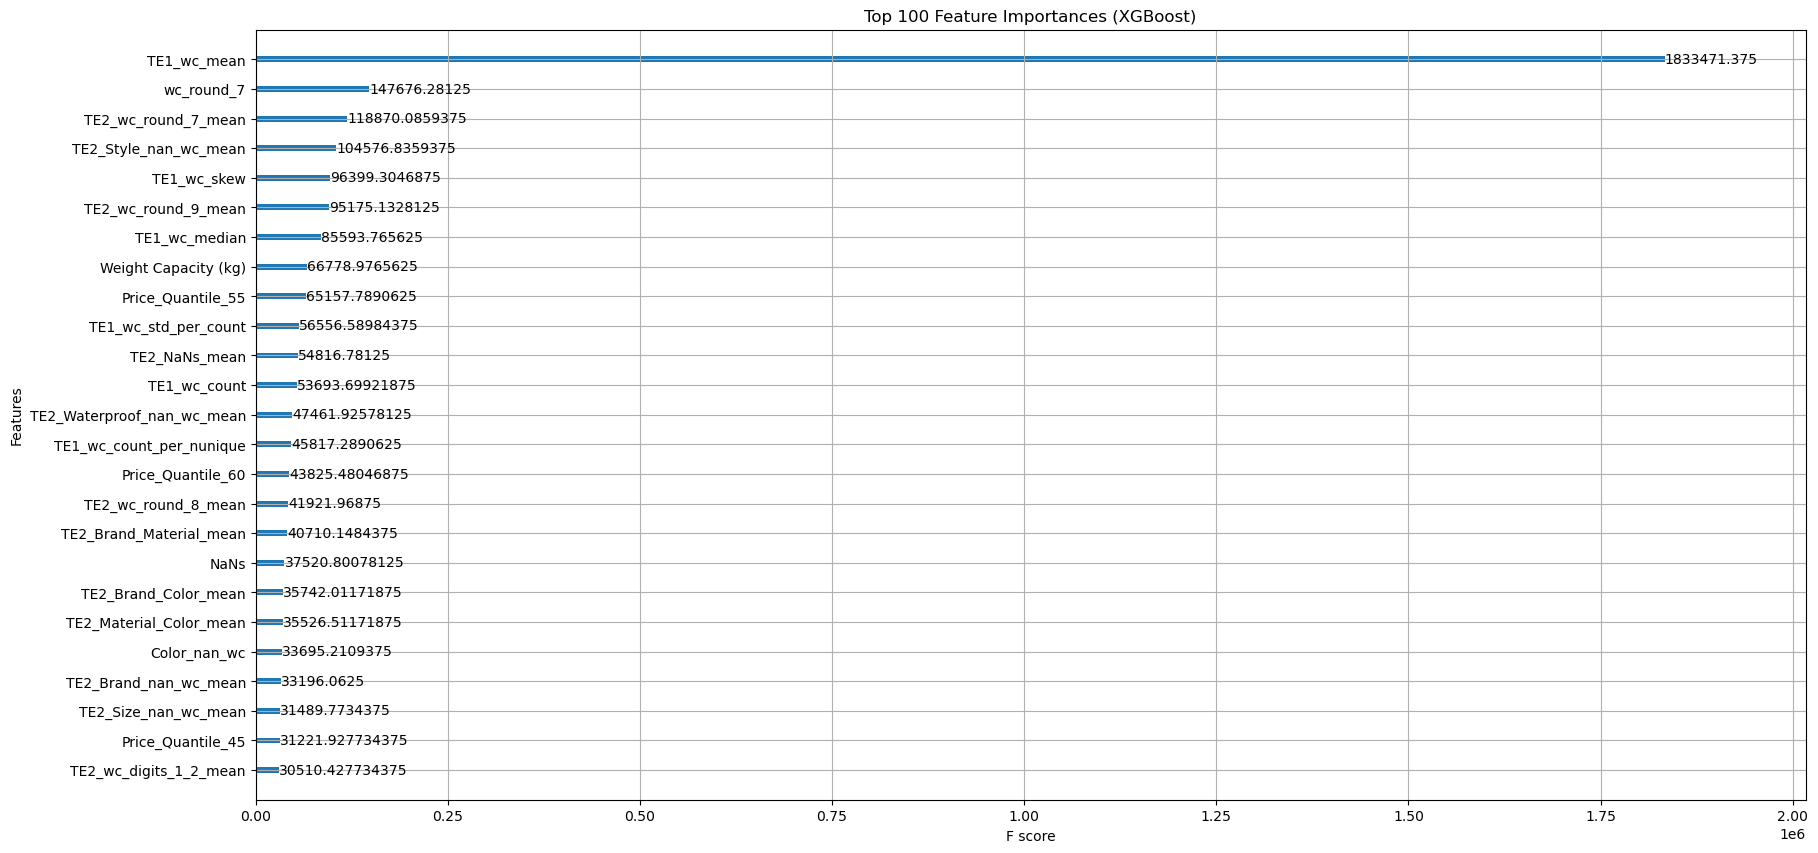

In [24]:
import xgboost as xgb
fig, ax = plt.subplots(figsize=(20, 10))
xgb.plot_importance(model, max_num_features=25, importance_type='gain',ax=ax)
plt.title("Top 100 Feature Importances (XGBoost)")
plt.show()

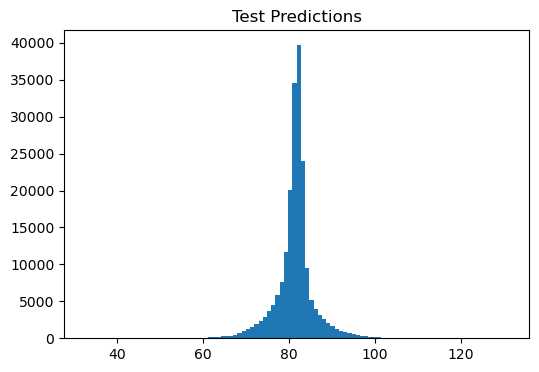

In [22]:
plt.figure(figsize=(6,4))
plt.hist(pred,bins=100)
plt.title("Test Predictions")
plt.show()

### !!! ERROR TRACE (%load_ext cudf.pandas)

- [CuPy CUDA](https://stackoverflow.com/questions/73961872/cupy-cuda-failed-to-import-cupy)
- [Numba CUDA - CUDA_ERROR_NO_DEVICE](https://github.com/numba/numba/issues/6777#issuecomment-1494852576)
- [WSL Linux CUDA](https://gist.github.com/Ayke/5f37ebdb84c758f57d7a3c8b847648bb)